# Visualizing registration experiment runs

Plot results from the registration runs with random initializations.
Animations are available in [animations.ipynb](https://nbviewer.org/github/eigenvivek/DiffDRR/tree/main/experiments/registration/animations.ipynb).

To run the registration experiment, run the following in the home directory:

```python experiments/registration/reg.py --n_drrs=1000```

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
colors = {True: "#e7298a", False: "#7570b3"}

def converged(df, cutoff, max_itr):
    return (df["loss"].iloc[-1] <= cutoff) or (df["itr"].iloc[-1] < max_itr - 1)

In [4]:
def plot(optimizer, scipy=False, max_itr=250, cutoff=-0.999, max_runtime=12.25, debug=False):
    fig = plt.figure(dpi=300, figsize=plt.figaspect(1/3))
    gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1], figure=fig)
    ax_plot = plt.subplot(gs[0])
    ax_hist = plt.subplot(gs[1])

    # Plot the training trajectories
    dfs = []
    kwargs = {"alpha": 0.1, "lw": 1.25}
    for file in Path(f"results/{optimizer}/runs").glob("*.csv"):
        df = pd.read_csv(file)
        if len(df) > max_itr:
            df = df.iloc[:max_itr]
        if scipy:
            df["runtime"] = df["time"]
            df["itr"] = df.index
        else:
            df["runtime"] = df["time"].cumsum()
        df["converged"] = converged(df, cutoff, max_itr)
        color = colors[converged(df, cutoff, max_itr)]
        ax_plot.plot(df["itr"], df["loss"], color, **kwargs)
        dfs.append(df.iloc[-1])
    ax_plot.set(xlabel="Iteration", ylabel="Negative ZNCC")
    ax_plot.set_title(f"(a) Loss curves for {len(dfs)} simulated DRRs", loc="left")

    # Plot the convergence timing histogram
    df = pd.concat(dfs, axis=1).T.reset_index(drop=True)
    sns.histplot(data=df, x="runtime", hue="converged", hue_order=[True, False], multiple="stack", palette=colors, legend=True, ax=ax_hist, bins=20)
    sns.move_legend(ax_hist, loc="upper left", bbox_to_anchor=(-0.75, 1), title="Converged", frameon=False)
    ax_hist.set(xlabel="Runtime (s)", xlim=(0, max_runtime))
    ax_hist.set_title("(b) Total optimization time", loc="left")

    # Get optimization timing metrics
    n_conv = df["converged"].astype(int).sum()
    t_conv = df.query("converged == True")["runtime"].mean()
    s_conv = df.query("converged == True")["runtime"].std()
    nitr_conv = df.query("converged == True")["itr"].mean()
    sitr_conv = df.query("converged == True")["itr"].std()
    print(f"""{n_conv}/{len(df)} ({n_conv/len(df):.2%}) runs achieved convergence in {t_conv:.2f}±{s_conv:.2f}s ({nitr_conv:.2f}±{sitr_conv:.2f} iterations) on average""")
    plt.show()
    
    if debug:  # Return compiled runtimes
        return pd.concat(dfs, axis=1).T.reset_index(drop=True)

669/1000 (66.90%) runs achieved convergence in 3.55±1.22s (113.16±37.96 iterations) on average


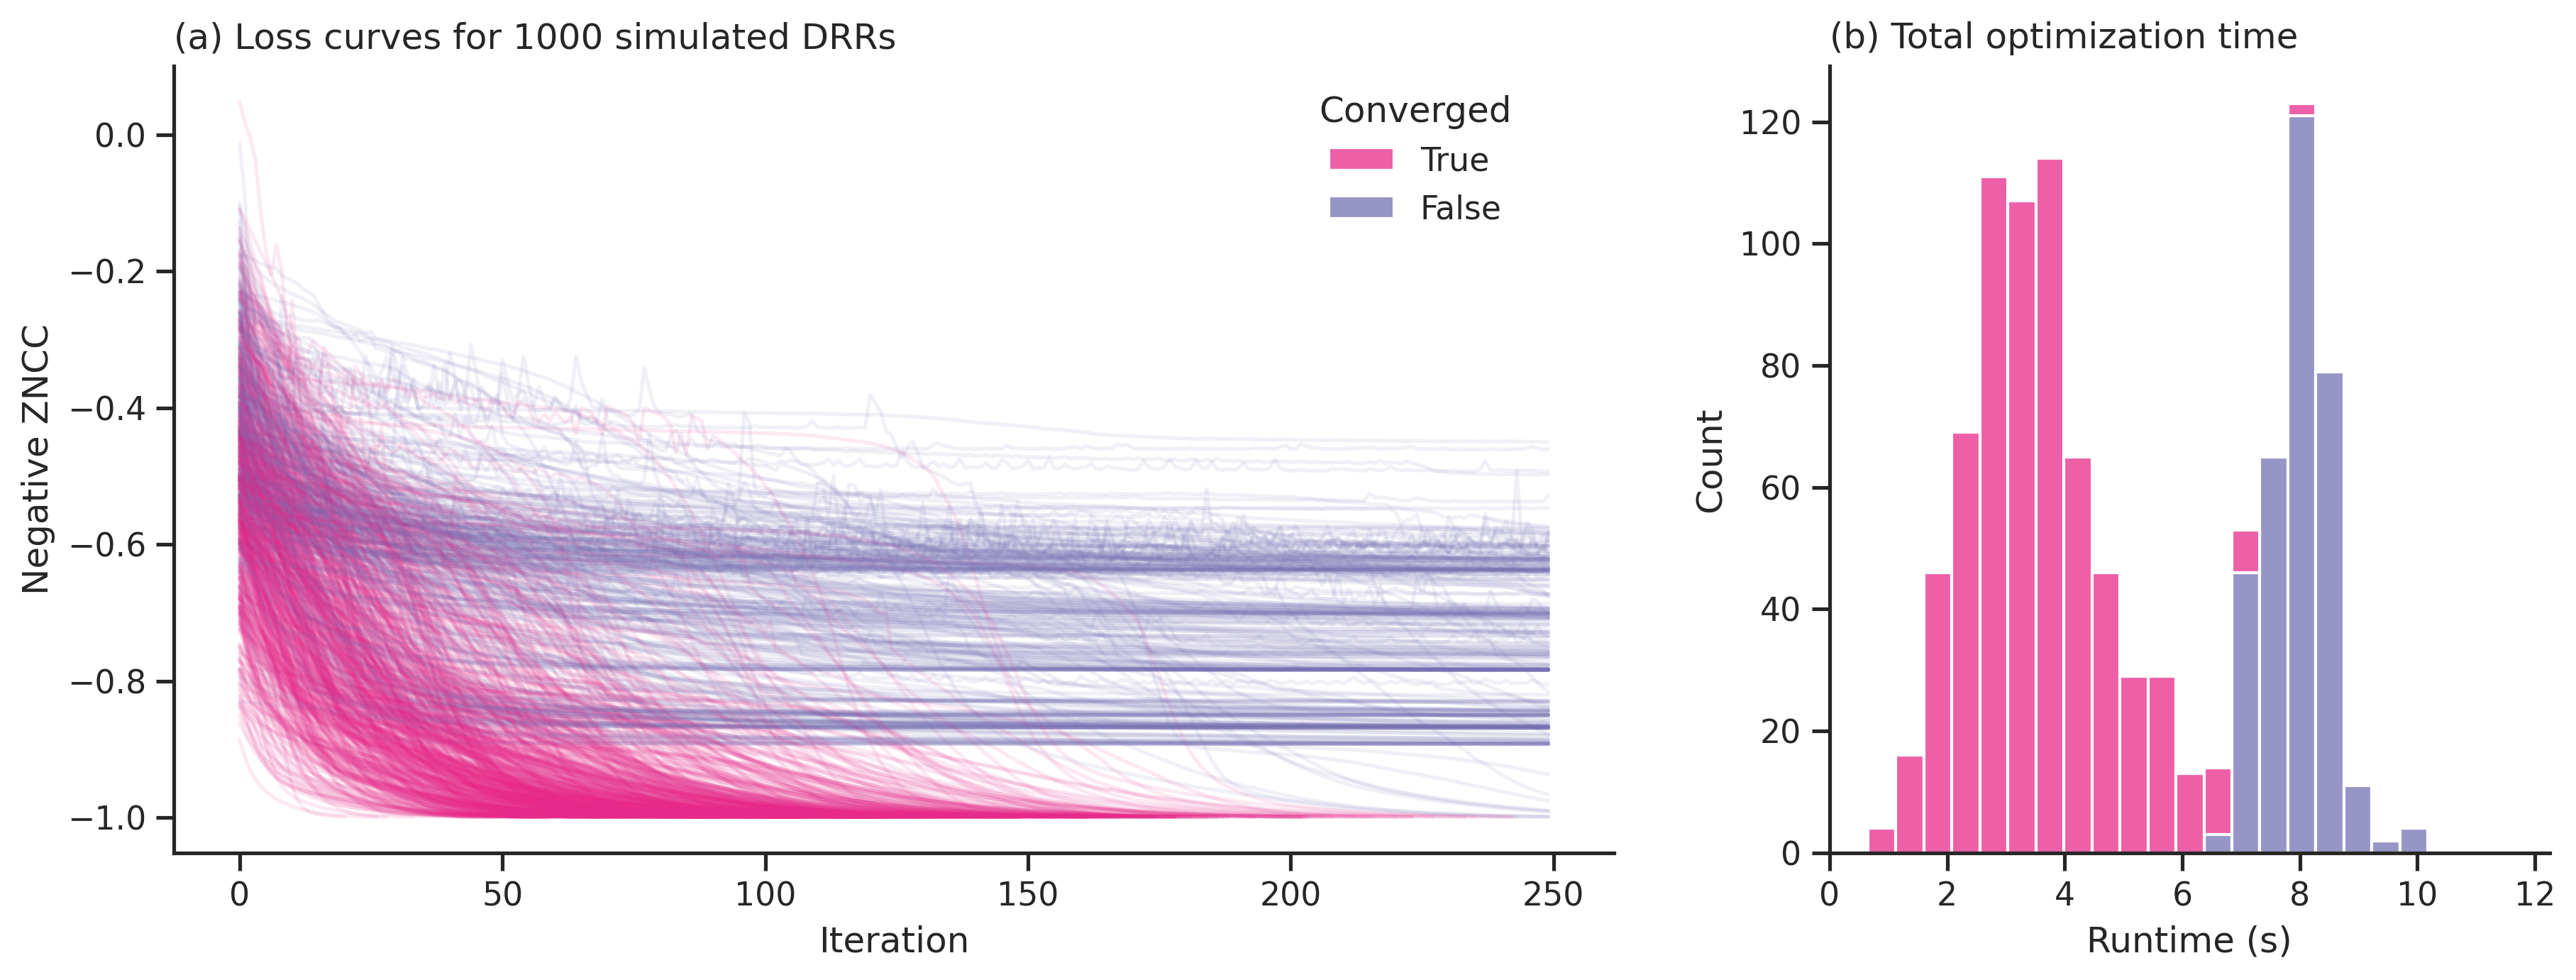

In [5]:
# Basic SGD
plot("base")

742/1000 (74.20%) runs achieved convergence in 1.81±0.45s (65.23±15.41 iterations) on average


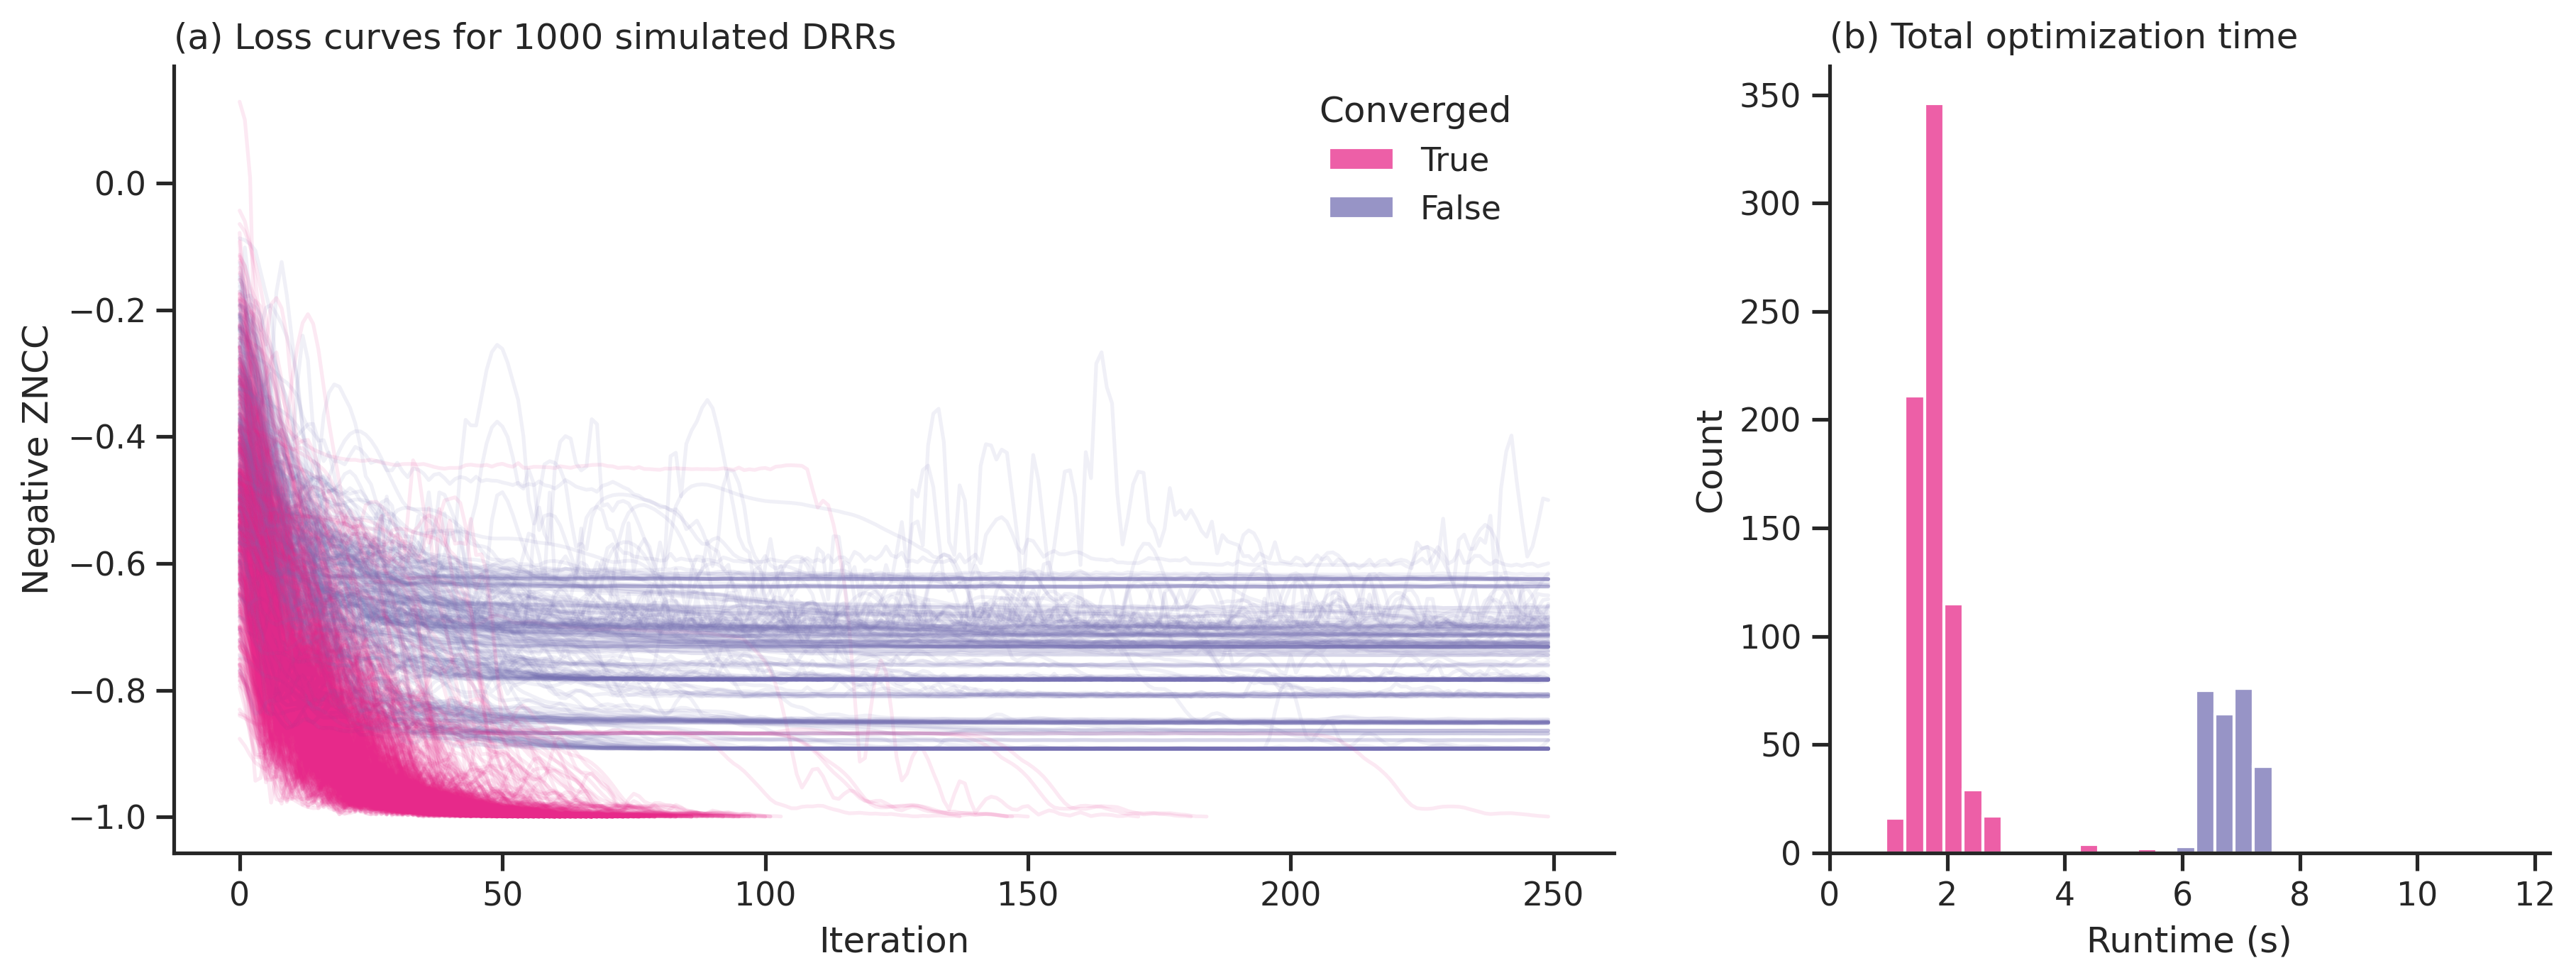

In [7]:
# Basic SGD + momentum
plot("momentum")

782/1000 (78.20%) runs achieved convergence in 1.84±0.51s (66.38±17.42 iterations) on average


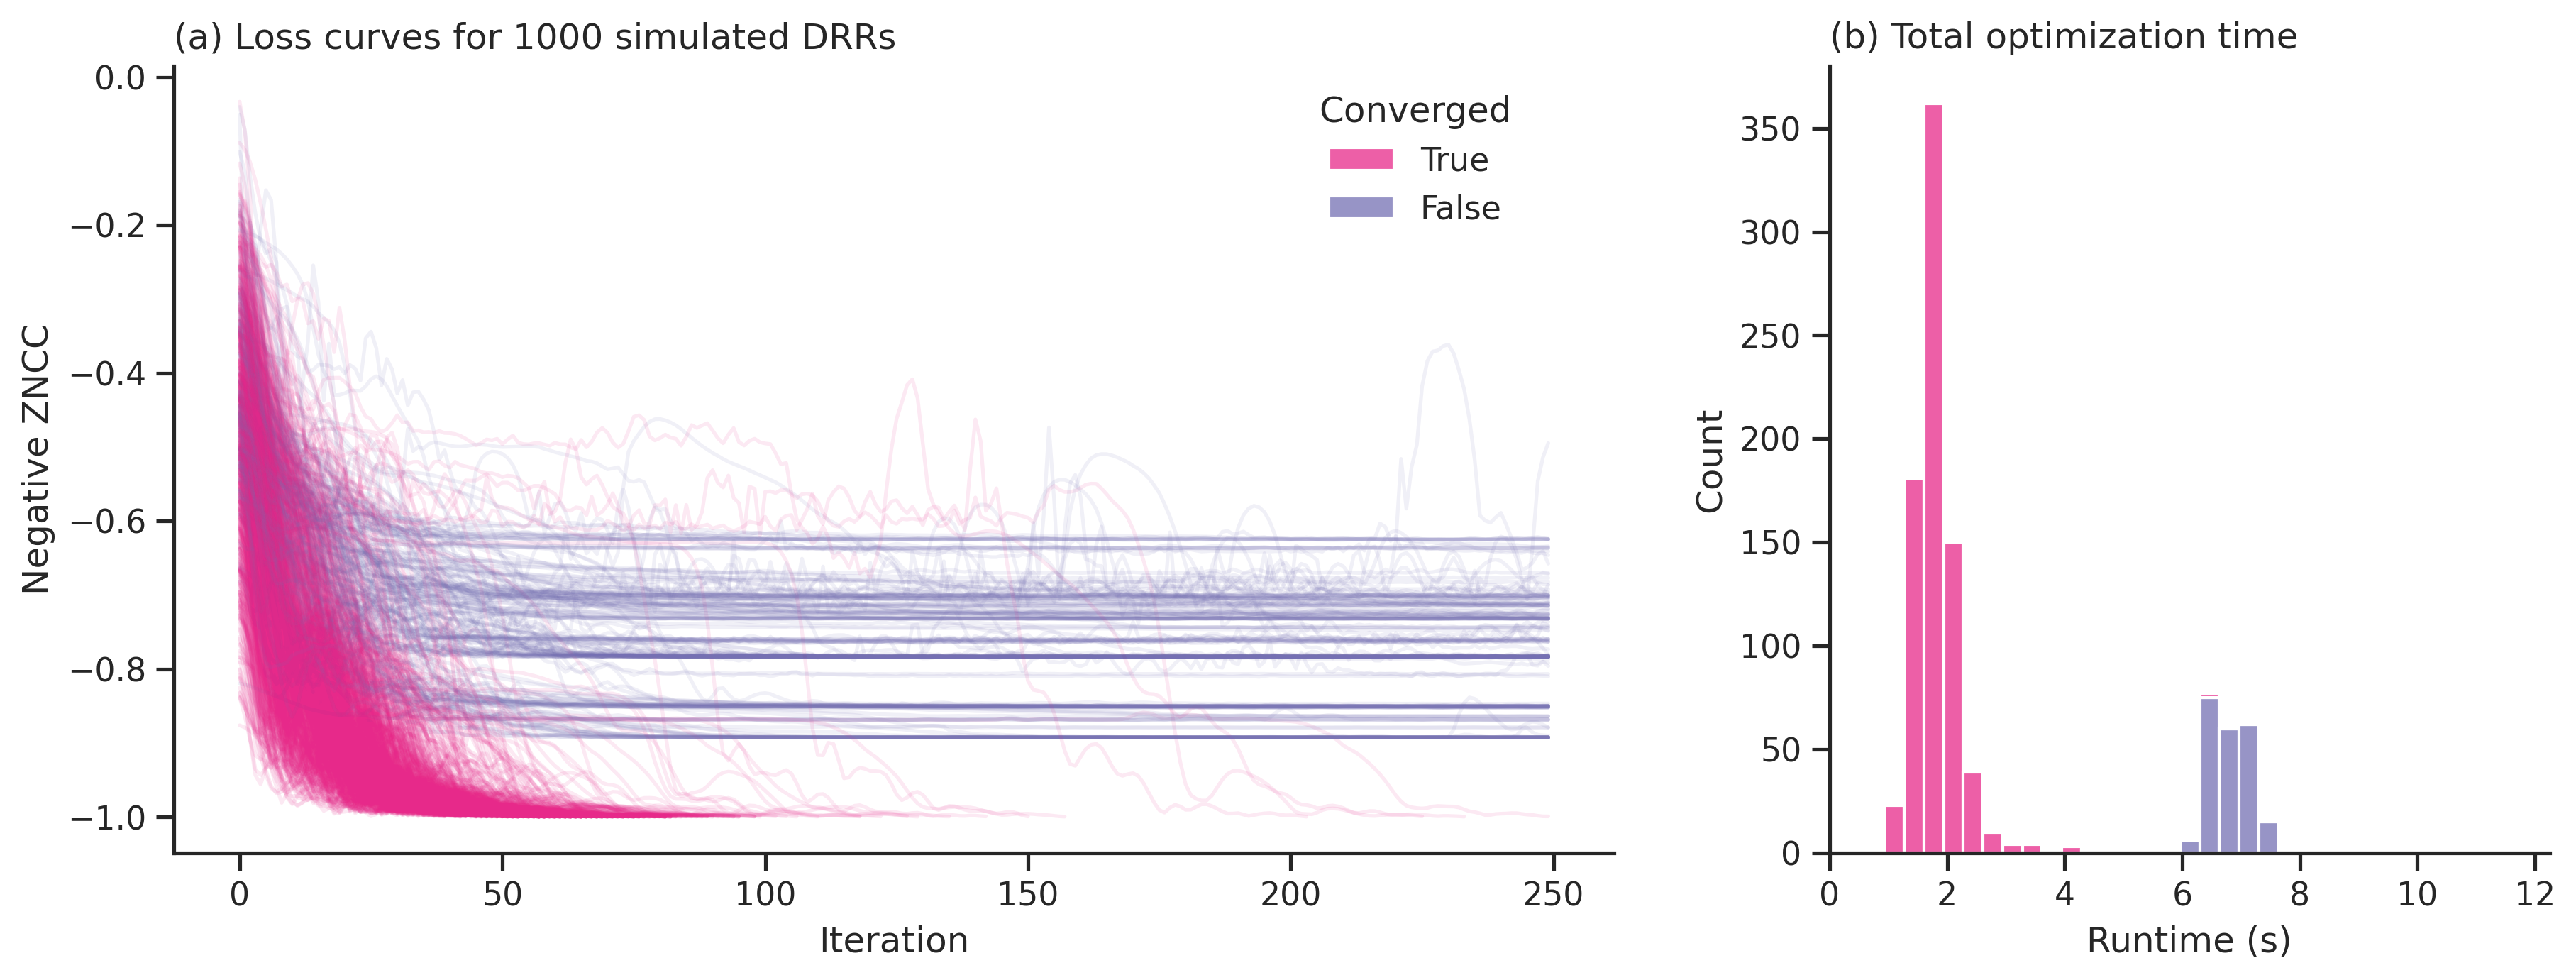

In [6]:
# Basic SGD + momentum + dampening
plot("momentum_dampen")

659/1000 (65.90%) runs achieved convergence in 7.53±0.89s (446.24±54.61 iterations) on average


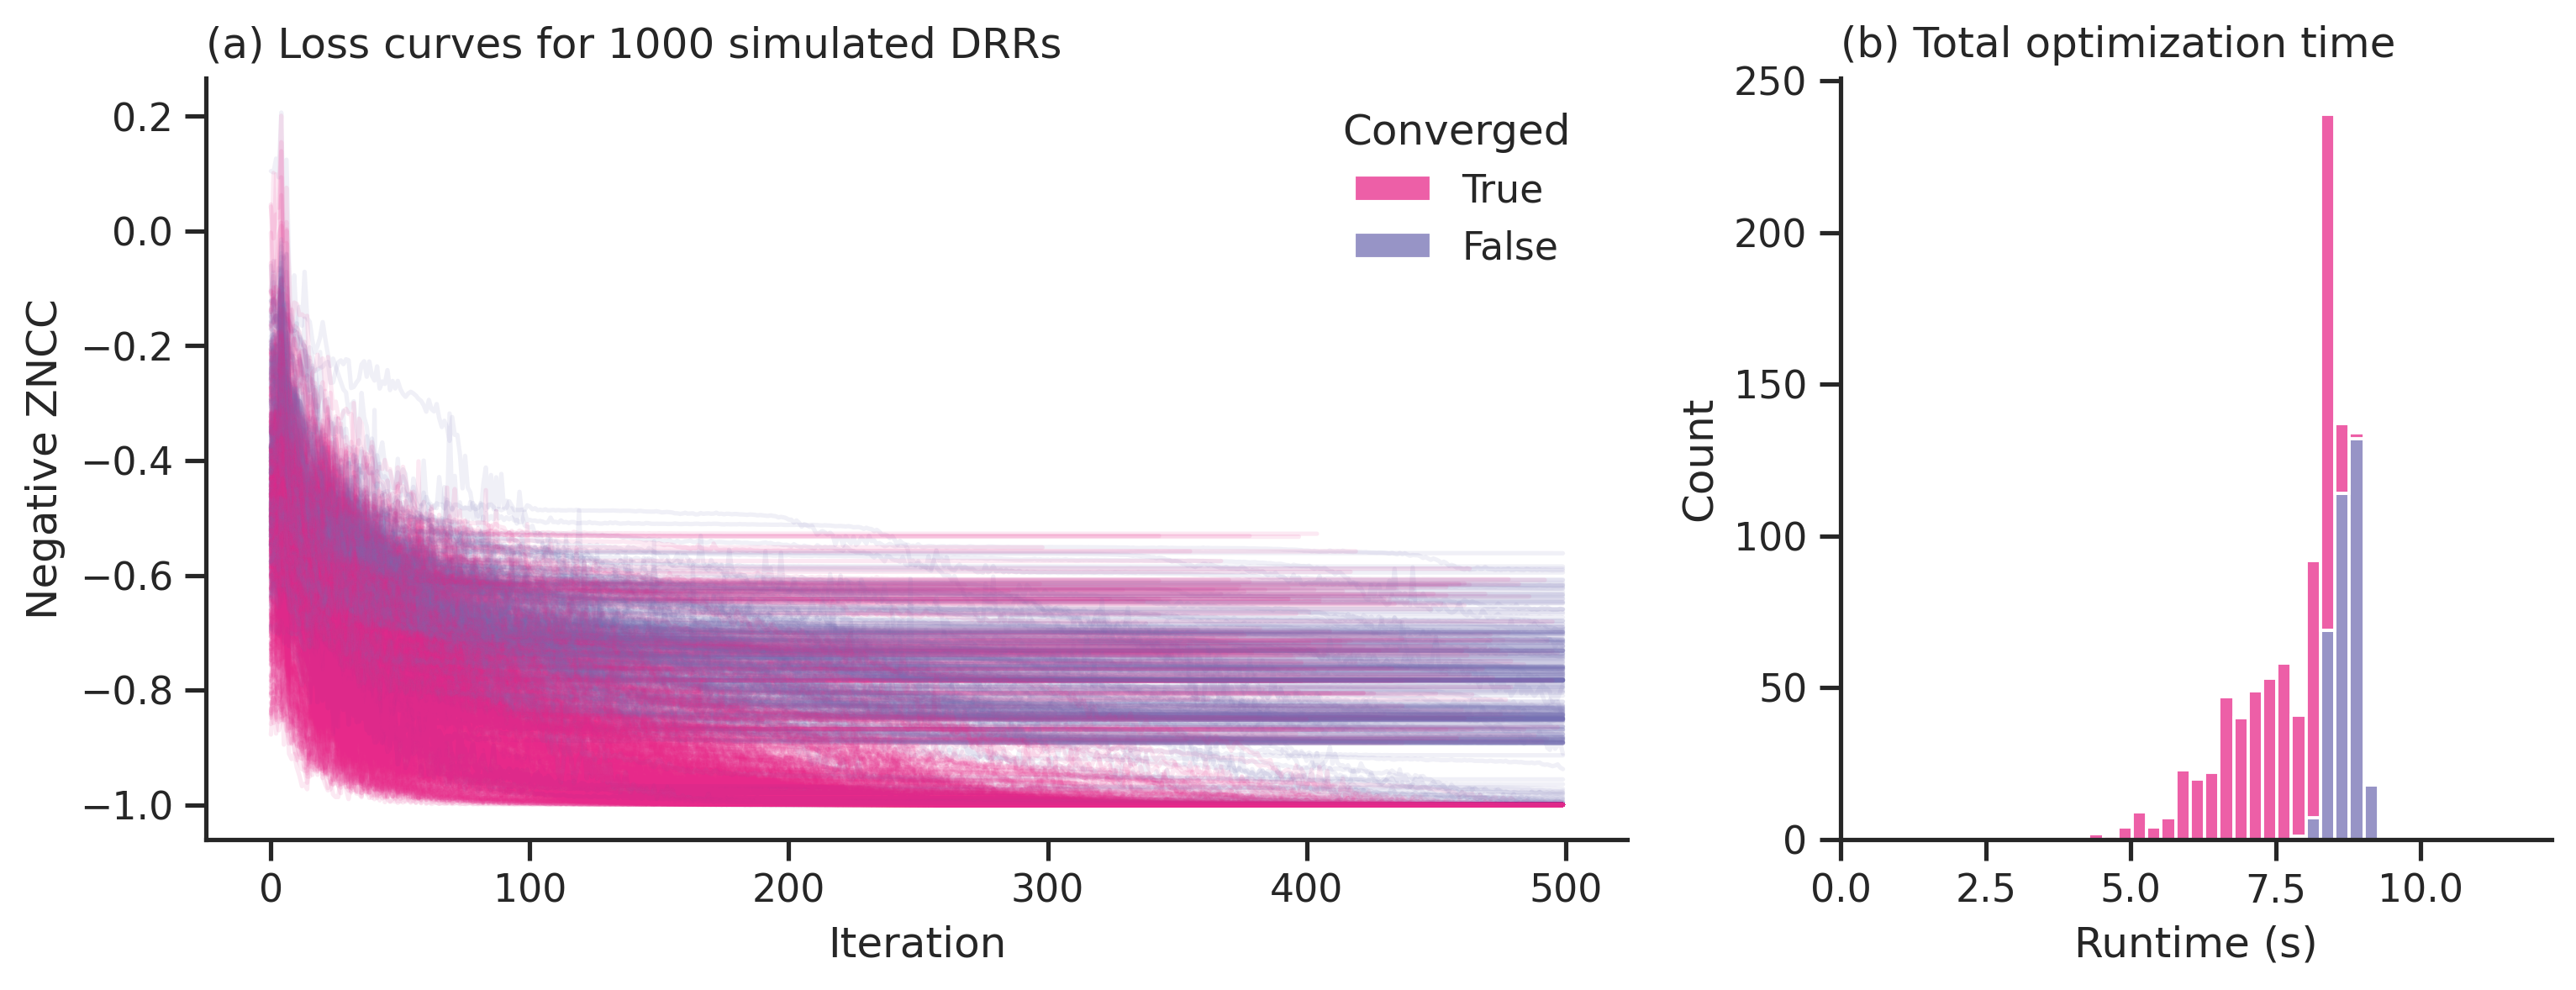

In [8]:
# Nelder-Mead
plot("neldermead", scipy=True, max_itr=500)

474/1000 (47.40%) runs achieved convergence in 9.30±12.98s (13.91±29.63 iterations) on average


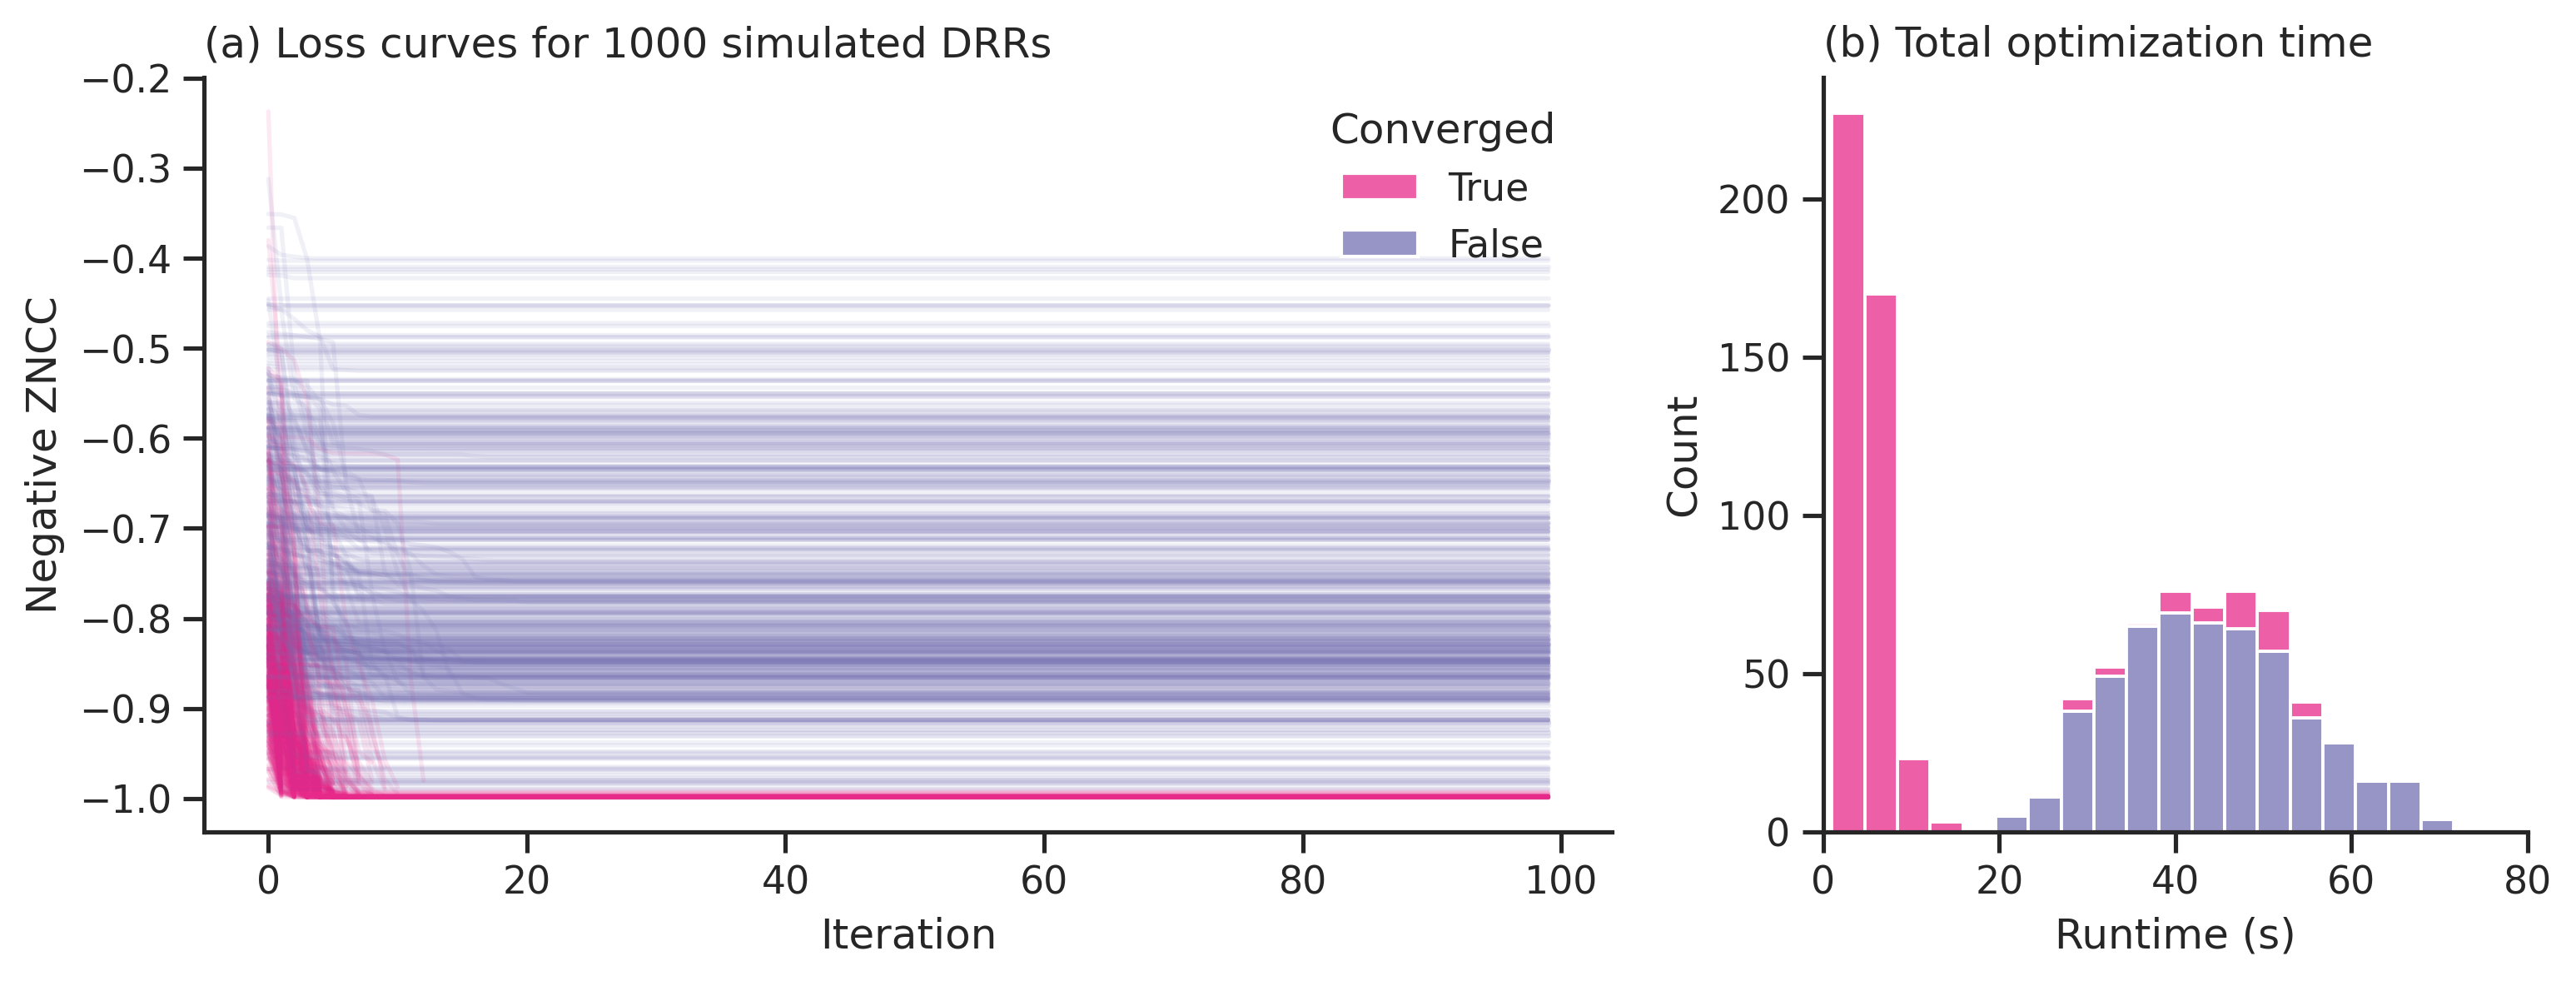

In [9]:
# L-BFGS
plot("lbfgs", cutoff=-0.99, max_runtime=80, max_itr=100)

In [10]:
from diffdrr import load_example_ct, DRR, plot_drr


# Utility functions for plotting DRRs
volume, spacing = load_example_ct()
drr = DRR(volume, spacing, height=100, delx=10.0, device="cuda")


def plot_df(df, idx, ax, sdr=200):
    
    # Make the DRR
    params = df.iloc[idx][["theta", "phi", "gamma", "bx", "by", "bz"]].values
    img = drr(sdr, *params)
    
    # Make the title
    loss = df.iloc[idx]["loss"]
    if idx == 0:
        itr = "Initial Guess"
    elif idx == -1:
        itr = "Final Guess"
    else:
        itr = f"Iteration {idx}"
    title = f"{itr}\n-ZNCC={loss:.2f}"
    
    # Make the plot
    plot_drr(img, ax=ax, ticks=False)
    ax.set(xlabel=title)


def plot_a_few_drrs(df, int_1, int_2, axs):
    plot_df(df, 0, axs[0])
    plot_df(df, int_1, axs[1])
    plot_df(df, int_2, axs[2])
    plot_df(df, -1, axs[3])

776/1000 (77.60%) runs achieved convergence in 2.07±0.43s (65.98±13.78 iterations) on average


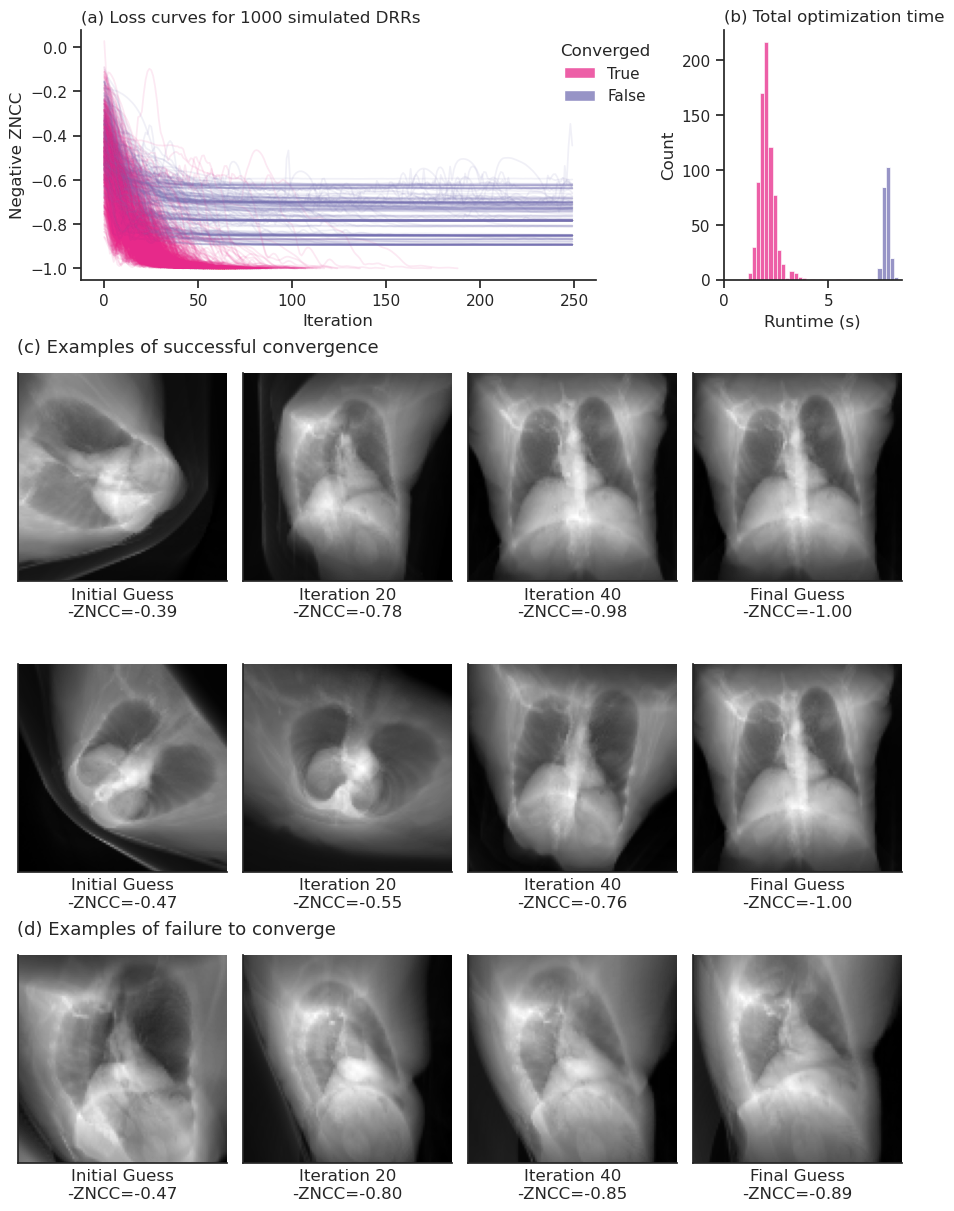

In [12]:
fig = plt.figure(dpi=100, figsize=(9, 12), constrained_layout=True)
subfigs = fig.subfigures(4, 1, wspace=0.1, height_ratios=[1.15, 1, 1, 1])

charts = subfigs[0].subfigures(1, 2, width_ratios=[2, 1])
ax_plot = charts[0].subplots()
ax_hist = charts[1].subplots()

# Plot the training trajectories
dfs = []
kwargs = {"alpha": 0.1, "lw": 1.25}
for file in Path("results/momentum_dampen/runs/").glob("*.csv"):
    df = pd.read_csv(file)
    df["runtime"] = df["time"].cumsum()
    df["converged"] = converged(df, cutoff=-0.999, max_itr=250)
    color = colors[converged(df, cutoff=-0.999, max_itr=250)]
    ax_plot.plot(df["itr"], df["loss"], color, **kwargs)
    dfs.append(df.iloc[-1])
ax_plot.set(xlabel="Iteration", ylabel="Negative ZNCC")
ax_plot.set_title(f"(a) Loss curves for {len(dfs)} simulated DRRs", loc="left")

# Plot the convergence timing histogram
df = pd.concat(dfs, axis=1).T.reset_index(drop=True)
sns.histplot(data=df, x="runtime", hue="converged", hue_order=[True, False], multiple="stack", palette=colors, legend=True, ax=ax_hist)
sns.move_legend(ax_hist, loc="upper left", bbox_to_anchor=(-1, 1), title="Converged", frameon=False)
ax_hist.set(xlabel="Runtime (s)", xlim=(0, 8.5))
ax_hist.set_title("(b) Total optimization time", loc="left")

# Get optimization timing metrics
n_conv = df["converged"].astype(int).sum()
t_conv = df.query("converged == True")["runtime"].mean()
s_conv = df.query("converged == True")["runtime"].std()
nitr_conv = df.query("converged == True")["itr"].mean()
sitr_conv = df.query("converged == True")["itr"].std()
print(f"""{n_conv}/{len(df)} ({n_conv/len(df):.2%}) runs achieved convergence in {t_conv:.2f}±{s_conv:.2f}s ({nitr_conv:.2f}±{sitr_conv:.2f} iterations) on average""")

# Plot a few examples of convergence
subfigs[1].suptitle(
    "(c) Examples of successful convergence",
    x=0.0125,
    y=1,
    horizontalalignment='left',
    verticalalignment='top',
    fontsize=13,
)
axs = subfigs[1].subplots(ncols=4)
df = pd.read_csv("results/momentum_dampen/runs/34.csv")
plot_a_few_drrs(df, 20, 40, axs)

axs = subfigs[2].subplots(ncols=4)
df = pd.read_csv("results/momentum_dampen/runs/22.csv")
plot_a_few_drrs(df, 20, 40, axs)

# And one example of failure to converge
subfigs[3].suptitle(
    "(d) Examples of failure to converge",
    x=0.0125,
    y=1,
    horizontalalignment='left',
    verticalalignment='top',
    fontsize=13,
)
axs = subfigs[3].subplots(ncols=4)
df = pd.read_csv("results/momentum_dampen/runs/59.csv")
plot_a_few_drrs(df, 20, 40, axs)

# Save the final figure!
plt.savefig("../../figures/optimization.pdf", bbox_inches="tight")
plt.show()